# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
#!pip install tensorflow_text

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Conv1D, Input
from tensorflow.keras.layers import Add, Dense, Dropout, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.ops import round as tf_round
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.backend import set_value
from tensorflow.signal import stft, hann_window

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [6]:
from tensorflow.keras import initializers

initializer_for_relu = initializers.HeNormal() # For layers with activation function Relu
initializer_for_sigmoid = initializers.GlorotNormal() # For layers with activation function Sigmoid

In [7]:
from tensorflow.keras.utils import plot_model

In [8]:
import tensorboard
#import visualkeras

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Import Data

In [10]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = '/content/drive/MyDrive/MyColabProject/Data'
data_df = pd.read_csv(path+'/raw_nsepy_inp512_differencedVal_fourierTransform.csv')
data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-4.45,6.45,-3.1,3.00,3.10,-2.55,-3.25,9.45,1.55,-5.2,...,-3.25,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35
1,6.45,-3.10,3.0,3.10,-2.55,-3.25,9.45,1.55,-5.20,-4.0,...,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05
2,-3.10,3.00,3.1,-2.55,-3.25,9.45,1.55,-5.20,-4.00,1.5,...,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05,1.70


In [12]:
data_df.shape

(41412, 513)

## Train Test Split

In [13]:
data_df.iloc[:2400,256:].shape

(2400, 257)

In [14]:
data_df.iloc[:2400,256:].head(3)

,256,257,258,259,260,261,262,263,264,265,...,503,504,505,506,507,508,509,510,511,512
0,2.75,-0.40,-1.65,-0.85,-1.0,0.30,3.90,7.85,2.75,4.30,...,-3.25,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35
1,-0.40,-1.65,-0.85,-1.00,0.3,3.90,7.85,2.75,4.30,-5.35,...,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05
2,-1.65,-0.85,-1.00,0.30,3.9,7.85,2.75,4.30,-5.35,-0.25,...,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05,1.70


In [15]:
data_q1 = data_df.iloc[:9600,:129].copy()
data_q2 = data_df.iloc[:9600,128:257].copy()
data_q3 = data_df.iloc[:9600,256:385].copy()
data_q4 = data_df.iloc[:9600,384:].copy()
data_df_merged = pd.DataFrame()
data_df_merged = pd.concat([pd.DataFrame(data_q1.values),pd.DataFrame(data_q2.values),pd.DataFrame(data_q3.values),pd.DataFrame(data_q4.values)],
                           ignore_index=True)
print(data_df_merged.shape)
data_df_merged.head(3)

(38400, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-4.45,6.45,-3.1,3.00,3.10,-2.55,-3.25,9.45,1.55,-5.2,...,-7.65,-1.25,0.00,8.00,-6.05,1.80,-0.75,-0.9,-0.1,-2.8
1,6.45,-3.10,3.0,3.10,-2.55,-3.25,9.45,1.55,-5.20,-4.0,...,-1.25,0.00,8.00,-6.05,1.80,-0.75,-0.90,-0.1,-2.8,-1.5
2,-3.10,3.00,3.1,-2.55,-3.25,9.45,1.55,-5.20,-4.00,1.5,...,0.00,8.00,-6.05,1.80,-0.75,-0.90,-0.10,-2.8,-1.5,0.5


In [16]:
data_df_merged.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
38397,1.55,-2.20,-3.35,1.0,21.0,9.70,-7.70,-4.85,9.05,6.80,...,4.0,8.00,9.00,-7.85,25.40,-5.55,1.6,-13.5,-10.10,3.00
38398,-2.20,-3.35,1.00,21.0,9.7,-7.70,-4.85,9.05,6.80,2.75,...,8.0,9.00,-7.85,25.40,-5.55,1.60,-13.5,-10.1,3.00,18.45
38399,-3.35,1.00,21.00,9.7,-7.7,-4.85,9.05,6.80,2.75,-2.35,...,9.0,-7.85,25.40,-5.55,1.60,-13.50,-10.1,3.0,18.45,31.55


In [17]:
inp_len = 128 # Length of the input
out_len = 1 # Length of Output and Context

In [18]:
prediction_percentage = 0.1 #0.025
train_df, test_df = train_test_split(data_df_merged, test_size=prediction_percentage, random_state=1, shuffle=True)

In [19]:
print('Train shape',train_df.shape)
print('Test shape',test_df.shape)

Train shape (34560, 129)
Test shape (3840, 129)


In [20]:
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=1, shuffle=True)

In [21]:
print('Train shape',train_df.shape)
print('Validation shape',val_df.shape)
print('Test shape',test_df.shape)

Train shape (25920, 129)
Validation shape (8640, 129)
Test shape (3840, 129)


Keras Model.fit training expects (inputs, labels) pairs. The inputs is tokenized sequences. The labels are the same sequences shifted by 1. This shift is so that at each location input sequence, the label in the next token.

In [22]:
X_train = train_df.drop(columns=train_df.columns[inp_len:].values).values
y_train = train_df.drop(columns=train_df.columns[:inp_len].values).values

X_val = val_df.drop(columns=val_df.columns[inp_len:].values).values
y_val = val_df.drop(columns=val_df.columns[:inp_len].values).values

X_test = test_df.drop(columns=test_df.columns[inp_len:].values).values
y_test = test_df.drop(columns=test_df.columns[:inp_len].values).values

In [23]:
print('X Train shape',X_train.shape)
print('Y Train shape',y_train.shape)

print('X Validation shape',X_val.shape)
print('Y Validation shape',y_val.shape)

print('X Test shape',X_test.shape)
print('Y Test shape',y_test.shape)

X Train shape (25920, 128)
Y Train shape (25920, 1)
X Validation shape (8640, 128)
Y Validation shape (8640, 1)
X Test shape (3840, 128)
Y Test shape (3840, 1)


In [24]:
X_train_f = X_train.astype(np.float32)
y_train_t = tf.convert_to_tensor(y_train)
X_val_f = X_val.astype(np.float32)
y_val_t = tf.convert_to_tensor(y_val)
X_test_f = X_test.astype(np.float32)
y_test_t = tf.convert_to_tensor(y_test)

In [25]:
X_train_f[0]

array([ 1.35, -1.15, -1.5 , -4.2 , -2.3 ,  5.  , -2.  ,  0.  ,  1.75,
        0.3 ,  0.95, -0.15,  0.15,  2.45, -0.2 ,  0.15, -1.95, -1.55,
       -0.7 ,  2.45, -2.05,  0.9 ,  2.9 , -0.5 , -0.5 , -2.2 , -1.2 ,
        0.25,  1.35,  2.25,  2.4 , -2.25, -5.5 ,  0.  ,  2.  , -0.9 ,
        0.35, -0.85,  0.  ,  3.4 , -2.5 ,  0.  ,  1.  ,  0.7 ,  1.35,
        3.9 , -2.  , -0.7 ,  0.9 ,  1.65, -1.85,  1.25, -0.2 ,  0.9 ,
        2.8 ,  2.7 , -0.4 ,  3.3 , -2.65,  0.8 , -1.25,  3.5 , -4.15,
       -0.7 ,  0.95, -3.75,  1.15, -2.55, -1.3 ,  1.3 ,  2.15,  0.8 ,
        2.7 , -1.9 , -0.55,  2.25, -0.1 , -2.  , -3.65, -2.35, -1.25,
       -1.65,  2.55, -1.15,  2.8 , -0.2 , -1.1 ,  1.9 ,  0.75,  2.95,
        0.85, -0.1 , -1.55,  2.4 , -1.2 ,  1.6 ,  1.5 , -5.1 ,  2.9 ,
        0.55, -0.45, -2.  , -1.7 ,  1.65, -0.95,  0.95,  0.05, -0.05,
        2.05,  0.  , -3.4 ,  2.3 , -0.1 , -1.3 ,  1.45,  2.8 ,  5.25,
       -1.2 ,  3.2 , -0.65,  1.65, -0.1 ,  1.3 , -2.2 ,  1.5 ,  0.  ,
       -2.95,  2.85]

In [26]:
y_train[0]

array([-2.5])

In [27]:
y_train_t[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.5])>

## Testing tf.signal.stft

In [ ]:
spectrogram1 = tf.signal.stft(signals=X_train_f[0],
                              frame_length=512,
                              frame_step=1)

print(X_train[0].shape[0])
print(spectrogram1.shape)
print(spectrogram1)

In [ ]:
spectrogram2 = tf.signal.stft(X_train_f[0], frame_length=512, frame_step=256)

print(X_train[0].shape[0])
print(spectrogram2.shape)
print(spectrogram2)

In [ ]:
spectrogram3 = tf.signal.stft(X_train_f[0], frame_length=256, frame_step=128)

print(X_train[0].shape[0])
print(spectrogram3.shape)
print(spectrogram3)

In [ ]:
spectrogram4 = tf.signal.stft(X_train_f[0], frame_length=16, frame_step=8)

print(X_train[0].shape[0])
print(spectrogram4.shape)
print(spectrogram4)

## Hyperparameters

In [28]:
# Hyperparameters for Fourier Transform
signal_length = X_train.shape[1] # Length of the input time series
frame_length = [128, 64, 32, 16] # Hop size for Fourier Transform
frame_size = len(frame_length)
frame_step = [128, 64, 32, 16] # Hop size for Fourier Transform
fft_length = frame_length

# Hyperparameters for Attention Layer and DNN Layer
num_layers = [1, 1, 1, 1] # number of TransformerEncoderLayer layers (Original paper = 6)
num_heads = [1, 1, 1, 1] # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.3 # Dropout rate
regularizer_rate = 0.0001  # Use to regularizer the weights in attention model, smaller number for less data

# Index for testing
index_for_training = 1

In [29]:
# The STFT output shape can be defined as:
# Output Shape = (batch_size, 𝐹, 𝑇)
time_bins = list()
frequency_bins = list()
for i in np.arange(frame_size):
  print(i)
  # Number of Time Frames (T)
  time_bins.append(int(((signal_length - fft_length[i])/frame_step[i] )+1 ))
  print('Time Bins =',time_bins[i])

  # Number of Frequency Bins (F)
  frequency_bins.append(int(tf.math.floor((fft_length[i]/2) +1)))
  print('Frequency Bins =',frequency_bins[i])

  print('output_shape=[batch_size, time_bins, frequency_bins]')
  print('Output shape = (batch_size,',time_bins[i],',',frequency_bins[i],')\n')

0
Time Bins = 1
Frequency Bins = 65
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 1 , 65 )

1
Time Bins = 2
Frequency Bins = 33
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 2 , 33 )

2
Time Bins = 4
Frequency Bins = 17
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 4 , 17 )

3
Time Bins = 8
Frequency Bins = 9
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 8 , 9 )



## Fourier transform the data

In [30]:
test_list = list()
test_list.append([1,2,3])
test_list.append([4,5,6])
print(test_list)
print(np.array(test_list).shape)
type(test_list)

[[1, 2, 3], [4, 5, 6]]
(2, 3)


list

In [31]:
X_train_mag_sft = list()
X_train_ang_sft = list() # Disable it if using only magnitude as output
for x in X_train_f:
  spectrogram = tf.signal.stft(signals=x,
                                frame_length=frame_length[index_for_training],
                                frame_step=frame_step[index_for_training])
  magnitude_x = tf.math.abs(spectrogram)
  magnitude_x = tf_round(magnitude_x, 6)
  X_train_mag_sft.append(magnitude_x)


  angle_x = tf.math.angle(spectrogram) # Disable it if using only magnitude as output
  angle_x = tf_round(angle_x, 6) # Disable it if using only magnitude as output
  X_train_ang_sft.append(angle_x) # Disable it if using only magnitude as output

X_train_mag_sft = np.array(X_train_mag_sft)
X_train_ang_sft = np.array(X_train_ang_sft)# Disable it if using only magnitude as output

print('X Train shape',X_train_mag_sft.shape)
print('Y Train shape',X_train_ang_sft.shape)# Disable it if using only magnitude as output

X Train shape (25920, 2, 33)
Y Train shape (25920, 2, 33)


In [32]:
X_train_mag_sft[:2,:]

array([[[ 3.628165,  4.867398,  5.45529 ,  4.24388 ,  6.730792,
          2.940132,  2.795765, 10.580022, 17.570473, 15.57012 ,
         10.433193,  9.584463, 17.135492, 16.868511,  8.549971,
          9.730592, 11.812726, 12.99433 ,  7.491862,  2.819991,
          4.588328, 12.464535, 19.272793, 11.39491 ,  3.291244,
          7.054083,  7.078077,  5.926372,  2.259575,  4.702618,
          7.614174,  4.658922,  9.920465],
        [ 5.550483,  2.445843,  9.798174, 10.637927,  7.511242,
          0.640324,  7.896498,  4.13606 ,  7.423332,  3.636005,
          6.83016 ,  9.011802,  9.511871,  9.39445 , 12.035265,
          8.61053 , 11.119421,  6.080755,  2.195114, 10.179427,
         11.560271, 12.030488,  9.598571, 10.032577, 16.891884,
         14.837284, 10.808002, 13.644997, 17.537512, 13.53468 ,
          0.332248,  2.376394,  2.200029]],

       [[30.808052, 31.345287, 23.082432, 58.77882 , 53.73235 ,
         18.190409, 23.023348, 10.68029 , 46.138096, 53.868664,
         47.6130

In [33]:
X_train_ang_sft[:2,:]

array([[[ 0.      ,  1.160283, -2.846472, -0.487093,  2.615854,
         -1.280864,  1.099755, -0.668713,  2.67936 , -0.075226,
         -2.903859,  0.812879, -2.198707,  0.796112, -2.965424,
         -0.339178, -2.964579,  0.296416, -2.801004, -2.914842,
         -0.714946,  0.812898, -2.734428,  0.500069,  2.757086,
         -1.312731,  1.427245, -1.108631,  2.965925,  2.275136,
         -0.559246,  1.478358,  3.141593],
        [ 0.      ,  2.589724,  1.581636, -1.29993 , -2.889696,
          1.828108,  0.54111 ,  2.035932, -1.729048,  3.030548,
          1.171315, -0.65923 ,  2.66586 , -0.55677 ,  2.896433,
         -0.907868,  1.128423, -2.478794,  1.162873, -1.748346,
          0.833131, -3.016237,  0.466848, -1.740008,  1.707389,
         -1.637942,  0.363068, -2.784133,  1.005819, -2.18819 ,
          0.882722,  0.254083,  0.      ]],

       [[ 0.      , -2.089678,  2.553009,  0.174014, -2.863955,
          1.529988, -0.99492 , -3.066942,  0.630358, -2.893679,
         -0.0160

In [34]:
X_val_mag_sft = list()
X_val_ang_sft = list() # Disable it if using only magnitude as output
for x in X_val_f:
  spectrogram = tf.signal.stft(signals=x,
                                frame_length=frame_length[index_for_training],
                                frame_step=frame_step[index_for_training])
  magnitude_x = tf.math.abs(spectrogram)
  magnitude_x = tf_round(magnitude_x, 6)
  X_val_mag_sft.append(magnitude_x)


  angle_x = tf.math.angle(spectrogram) # Disable it if using only magnitude as output
  angle_x = tf_round(angle_x, 6) # Disable it if using only magnitude as output
  X_val_ang_sft.append(angle_x) # Disable it if using only magnitude as output

X_val_mag_sft = np.array(X_val_mag_sft)
X_val_ang_sft = np.array(X_val_ang_sft)# Disable it if using only magnitude as output

print('X Val shape',X_val_mag_sft.shape)
print('Y Val shape',X_val_ang_sft.shape)# Disable it if using only magnitude as output

X Val shape (8640, 2, 33)
Y Val shape (8640, 2, 33)


In [35]:
X_val_mag_sft[:2,:]

array([[[  4.517072,   6.650464,   7.239035,   6.513225,   3.054456,
           2.772098,  13.845219,  12.594712,  14.357996,   3.868162,
          10.664269,   8.353724,  14.663578,  22.176638,  16.422369,
          10.401872,   9.593398,   4.647878,  15.423323,  19.98079 ,
           9.829773,   7.347994,   9.644364,  13.722513,  19.876677,
          13.734456,  16.278368,  13.811651,   9.428608,  11.314852,
          14.378008,  16.399073,  15.220108],
        [ 12.179197,   3.634469,  11.987071,  14.63431 ,  10.955776,
           4.844231,   7.502619,  12.709834,  10.388758,   4.644338,
          12.522883,  23.058783,  23.401665,  11.011242,   8.274271,
          18.00824 ,   8.465965,  20.164532,  21.48767 ,   8.548125,
          14.845351,  26.973661,  22.062538,  12.720465,  26.447275,
          15.607803,   6.891268,   6.680814,  13.459414,  24.883959,
          26.484133,  33.45084 ,  38.888588]],

       [[164.84454 ,  79.181046,  48.69738 ,  85.195656,  37.559265,
         

In [36]:
X_val_ang_sft[:2,:]

array([[[ 3.141593, -0.164978,  2.8156  ,  1.625029, -1.849051,
         -1.917853,  0.235006,  3.035748, -1.040081,  2.923178,
          1.892963, -0.52047 ,  2.954768, -0.114683,  2.944522,
          0.179116, -2.484752, -0.271254,  2.03284 , -0.902994,
         -3.046188,  0.789962, -3.138664, -0.821151,  2.056946,
         -1.067494,  1.960946, -0.499567, -1.430559,  2.956974,
          1.079352, -1.291357,  3.141593],
        [ 0.      , -2.320046,  2.549428, -0.441215,  2.586092,
         -1.623896,  1.400709, -1.502923,  1.176595, -1.812989,
          2.38698 , -0.597556,  3.018213,  0.580193,  0.577084,
         -2.228736,  1.500285,  0.013405,  2.787529, -0.930859,
         -2.319424,  0.380714, -3.126716,  1.110282, -1.459792,
          1.218012, -3.093012, -2.569138,  1.835791, -0.50781 ,
          3.081756,  0.050885,  3.141593]],

       [[ 0.      ,  2.639021,  2.257153, -1.370895,  2.173336,
         -0.344106,  2.114967, -2.939922, -0.235747,  1.777693,
         -0.9472

In [37]:
X_test_mag_sft = list()
X_test_ang_sft = list() # Disable it if using only magnitude as output
for x in X_test_f:
  spectrogram = tf.signal.stft(signals=x,
                                frame_length=frame_length[index_for_training],
                                frame_step=frame_step[index_for_training])
  magnitude_x = tf.math.abs(spectrogram)
  magnitude_x = tf_round(magnitude_x, 6)
  X_test_mag_sft.append(magnitude_x)


  angle_x = tf.math.angle(spectrogram) # Disable it if using only magnitude as output
  angle_x = tf_round(angle_x, 6) # Disable it if using only magnitude as output
  X_test_ang_sft.append(angle_x) # Disable it if using only magnitude as output

X_test_mag_sft = np.array(X_test_mag_sft)
X_test_ang_sft = np.array(X_test_ang_sft)# Disable it if using only magnitude as output

print('X Train shape',X_test_mag_sft.shape)
print('Y Train shape',X_test_ang_sft.shape)# Disable it if using only magnitude as output

X Train shape (3840, 2, 33)
Y Train shape (3840, 2, 33)


In [38]:
X_test_mag_sft[:2,:]

array([[[ 16.457417,  21.57582 ,  19.065203,   7.272314,   6.734195,
          22.31165 ,  35.39542 ,  30.210705,  15.154134,   8.736283,
           5.912713,  16.94639 ,  26.630436,  23.869827,  15.674456,
          22.03447 ,  29.348284,  23.111307,  22.748455,  13.140301,
          10.703815,  13.059619,  21.176456,  20.777876,  16.517609,
          12.519138,   8.980583,   7.073736,  12.410907,  20.864517,
          16.44392 ,  13.755514,  10.055111],
        [  5.20162 ,   5.239324,   7.805542,   1.561002,  11.383781,
          13.391641,   4.619188,   9.286283,  11.07795 ,  21.560862,
          22.055164,  10.853859,  11.159704,   9.702897,  10.153553,
          10.385052,  24.070408,  29.2039  ,  16.886341,  26.969187,
           9.177596,  22.246548,  30.652273,  21.93574 ,  22.764275,
           8.674603,   8.869113,  17.479574,  16.124409,  18.939852,
          15.080609,  14.109388,   5.460981]],

       [[ 65.56251 ,  62.858376,  66.84363 ,  74.29295 ,  61.211853,
         

In [39]:
X_test_ang_sft[:2,:]

array([[[ 0.      , -2.923268, -0.065684,  2.163999,  2.339669,
         -1.797178,  1.068624, -2.159251,  0.352732,  2.272052,
          2.94831 , -1.129785,  1.587342, -1.712681,  1.92832 ,
         -0.340547,  3.101139, -0.569498,  1.635099, -1.350592,
          3.071831,  0.915154, -2.326206,  0.125918,  2.508061,
         -0.987288,  2.738274,  0.368371, -2.657514,  0.221415,
          2.709548, -0.802976,  3.141593],
        [ 0.      ,  1.968011, -1.971171, -1.249794,  0.482945,
         -2.671675,  2.506159,  0.547893, -0.264862, -3.022417,
         -0.148234,  3.135574,  2.622012, -0.415419,  2.130925,
          0.097595, -1.492291,  2.080453,  0.258285, -2.175221,
          1.316298,  0.499146, -2.331293,  1.980127, -0.605553,
          0.987905,  2.250738, -1.816068,  1.800518, -0.814703,
         -3.139912,  0.837552,  3.141593]],

       [[ 0.      , -2.557524,  1.136008, -1.877141,  1.075292,
         -1.423608,  2.537734, -0.794989,  2.059831, -0.011797,
         -2.5241

# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


<b>fft_length and frame_length</b>
* The number of frequency bins depends on the FFT size (fft_length), which is often set to the next power of 2 that is greater than or equal to frame_length
* example, if frame_lenght = 39, Next power of 2 greater than 39 is 64. Setting fft_length = 64 would allow the FFT algorithm to work more efficiently by padding the input to a length of 64.
* or choose frame_lenght any of 2, 4, 8, 16, 32, 64, ... <br>

<b>frame_step</b>
* To choose frame_step, 50% Overlap (a common choice): To achieve 50% overlap, set frame_step to half the frame_length: frame_step = frame_length/2
* example, if frame_length=8, then frame_step=8/2 = 4. This will give you overlapping frames, which improves frequency resolution.<br>

<b>Frequency_bins v/s time_bins</b>
*  have more Frequency_bins if identifying a long-term uptrend or downtrend based on weekly or monthly stock price data, or detecting cyclic behavior like seasonality.
* have more time_bins if Detecting intraday trends or anomalies (like a sudden price surge due to a news release).

# Model 1A

## Model Building

In [ ]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()

# Input Layer
input_mag_layer = Input(shape=(time_bins[index_for_training], frequency_bins[index_for_training]))
input_ang_layer = Input(shape=(time_bins[index_for_training], frequency_bins[index_for_training]))


# Layer 1 - self Attention for Angle (Multihead Attention + Add + LayerNorm)
lsa_ang_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                                   key_dim = frequency_bins[index_for_training],
                                   kernel_initializer = initializer_for_relu,
                                   kernel_regularizer=l2(regularizer_rate),
                                   bias_regularizer=l2(regularizer_rate),
                                   activity_regularizer=l2(regularizer_rate),
                                   dropout=dropout_rate
                                   )(input_ang_layer, input_ang_layer, input_ang_layer)
add_ang = Add()([input_ang_layer, lsa_ang_layer])
layerNorm_ang = LayerNormalization()(add_ang)

# Layer 2 - FFN for Angle (Dense + Add + LayerNorm)
dense_ang_1 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training],
                    activation='relu',
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate),
                    kernel_initializer=initializer_for_relu
                    )(layerNorm_ang)
dense_ang_2 = Dense(frequency_bins[index_for_training],# * time_bins[index_for_training],
                    activation='relu',
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate),
                    kernel_initializer=initializer_for_relu
                    )(dense_ang_1)
dense_ang_3 = Dense(frequency_bins[index_for_training],
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dense_ang_2)
dropout_ang = Dropout(dropout_rate)(dense_ang_3)
add_ffn_ang = Add()([layerNorm_ang, dropout_ang])
layerNorm_ffn_ang = LayerNormalization()(add_ffn_ang)

# Layer 3 - self Attention for Magnitude (Multihead Attention + Add + LayerNorm)
lsa_mag_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                                   key_dim = frequency_bins[index_for_training],
                                   kernel_initializer = initializer_for_relu,
                                   kernel_regularizer=l2(regularizer_rate),
                                   bias_regularizer=l2(regularizer_rate),
                                   activity_regularizer=l2(regularizer_rate),
                                   dropout=dropout_rate
                                   )(input_mag_layer, input_mag_layer, input_mag_layer)
add_mag = Add()([input_mag_layer, lsa_mag_layer])
layerNorm_mag = LayerNormalization()(add_mag)

# Layer 4 - Cross Attention for Magnitude and Angle (Multihead Attention + Add + LayerNorm)
gca_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                               key_dim = frequency_bins[index_for_training],
                               kernel_initializer = initializer_for_relu,
                               kernel_regularizer=l2(regularizer_rate),
                               bias_regularizer=l2(regularizer_rate),
                               activity_regularizer=l2(regularizer_rate),
                               dropout=dropout_rate
                               )(layerNorm_mag, layerNorm_ffn_ang, layerNorm_ffn_ang)
add_gca = Add()([layerNorm_mag, gca_layer])
layerNorm_gca = LayerNormalization()(add_gca)

# Layer 5 - FFN for Global Cross Attention (Dense + Add + LayerNorm)
dense_gca_1 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training],
                    activation='relu',
                    kernel_initializer=initializer_for_relu,
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(layerNorm_gca)
dense_gca_2 = Dense(frequency_bins[index_for_training],# * time_bins[index_for_training],
                    activation='relu',
                    kernel_initializer=initializer_for_relu,
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dense_gca_1)
dense_gca_3 = Dense(frequency_bins[index_for_training],
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dense_gca_2)
dropout_gca = Dropout(dropout_rate)(dense_gca_3)
add_ffn_gca = Add()([layerNorm_gca, dropout_gca])
layerNorm_ffn_gca = LayerNormalization()(add_ffn_gca)

# Layer 6 - Dense / Convolution
flatten_layer = Flatten()(layerNorm_ffn_gca)

out_dense_layer =  Dense(tf.get_static_value(tf.cast(signal_length, dtype=tf.int32)),
                         activation='relu',
                         kernel_initializer=initializer_for_relu,
                         kernel_regularizer=l2(regularizer_rate),
                         bias_regularizer=l2(regularizer_rate),
                         activity_regularizer=l2(regularizer_rate)
                         )(flatten_layer)
output_layer = Dense(1)(out_dense_layer)
# Output Layer
model_1A = Model(inputs=[input_mag_layer,input_ang_layer], outputs=output_layer)

In [ ]:
# Define the learning rate variable
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-8, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [ ]:
model_1A.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics=['R2Score'])

#Model Summary
model_1A.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2, 33)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 2, 33)          │          4,488 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 2, 33)          │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 2, 33)          │             66 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2, 66)          │          2,244 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2, 33)          │          2,211 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 2, 33)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2, 33)          │          1,122 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 2, 33)          │          4,488 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2, 33)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 2, 33)          │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 2, 33)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 2, 33)          │             66 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 2, 33)          │             66 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 33,653 (131.46 KB)

 Trainable params: 33,653 (131.46 KB)

 Non-trainable params: 0 (0.00 B)

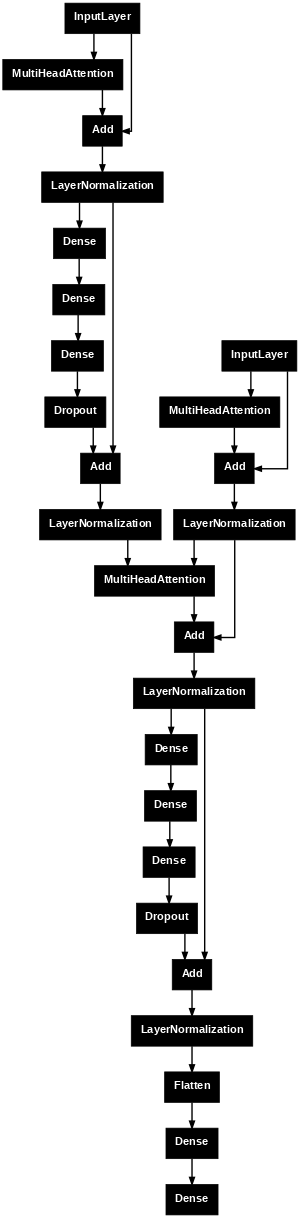

In [ ]:
plot_model(model_1A, dpi=50)

## Training

In [ ]:
path_model = '/content/drive/MyDrive/MyColabProject/Models/WithoutOOP'
checkpoint_filepath = (path_model+'/1A_Idea1_withoutOOP_1SF_nsepy_inp128_out1_FourierTransform_withInception.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/1A_Idea1_withoutOOP_1SF_nsepy_inp128_out1_FourierTransform_withInception.weights.h5


In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=10,
                               mode="min",
                               restore_best_weights=True)

In [ ]:
history_1 = model_1A.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        epochs=50, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - R2Score: -0.0093 - loss: 557.5003 - val_R2Score: 0.0116 - val_loss: 70.5915 - learning_rate: 0.0010
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - R2Score: 0.0157 - loss: 65.9487 - val_R2Score: 0.0273 - val_loss: 54.7158 - learning_rate: 0.0010
Epoch 3/50
518/810 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - R2Score: 0.0416 - loss: 55.7299

In [ ]:
history_2 = model_1A.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        initial_epoch=50, epochs=100, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

In [ ]:
history_3 = model_1A.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        initial_epoch=100, epochs=200, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

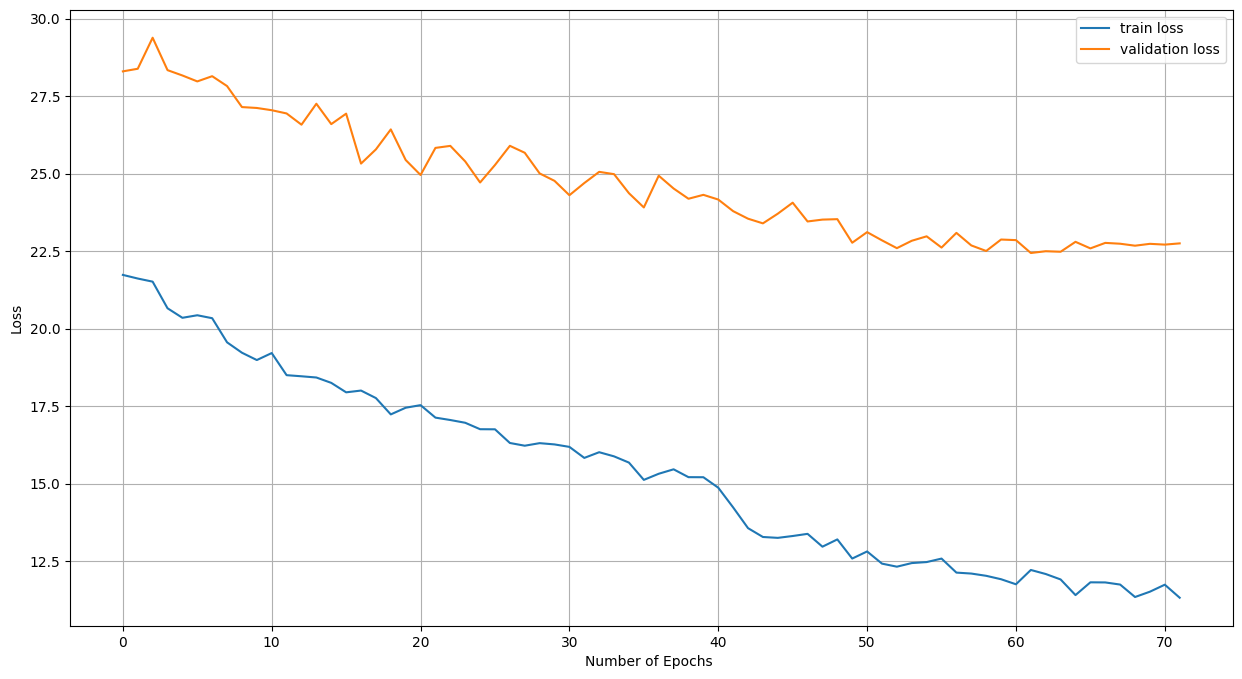

In [ ]:
# Train Loss
train_loss = list(history_1.history['loss'])
train_loss.extend(history_2.history['loss'])
#train_loss.extend(history_3.history['loss'])
#train_loss.extend(history_4.history['loss'])

# Validation Loss
val_loss = list(history_1.history['val_loss'])
val_loss.extend(history_2.history['val_loss'])
#val_loss.extend(history_3.history['val_loss'])
#val_loss.extend(history_4.history['val_loss'])

# plot history
plt.plot(np.array(train_loss[25:]), label='train loss')
plt.plot(np.array(val_loss[25:]), label='validation loss')
plt.xlabel("Number of Epochs ")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## Prediction - from Model

In [ ]:
predictions = model_1(([X_test_mag_sft, X_test_ang_sft]), training=False)

In [ ]:
predictions.shape

TensorShape([3840, 1])

In [ ]:
predictions[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.3492118], dtype=float32)>

In [ ]:
i = 12
print('Predictions = \n',predictions[i])
print('Actuals = \n',y_test[i])

Predictions = 
 tf.Tensor([-0.03869544], shape=(1,), dtype=float32)
Actuals = 
 [-0.9]


### Validating the results

In [ ]:
y_pred = predictions.numpy().reshape(-1)
y_test = y_test.reshape(-1)
print(y_pred.shape)
print(y_test.shape)

(3840,)
(3840,)


In [ ]:
score_mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error of our Model is {}".format(round(score_mae, 2)))
score_rmse = mean_squared_error(y_test, y_pred)
print("The Root Mean Squared Error of our Model is {}".format(round(score_rmse, 2)))
score_r2 = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score_r2, 2) *100))

The Mean Absolute Error of our Model is 2.71
The Root Mean Squared Error of our Model is 23.03
The accuracy of our model is 56.99999999999999%


In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,10000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()

# Model 1B - invert Angle and Magnitude

## Model Building

In [40]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()

# Input Layer
input_mag_layer = Input(shape=(time_bins[index_for_training], frequency_bins[index_for_training]))
input_ang_layer = Input(shape=(time_bins[index_for_training], frequency_bins[index_for_training]))


# Layer 1 - self Attention for Magnitude (Multihead Attention + Add + LayerNorm)
lsa_mag_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                                   key_dim = frequency_bins[index_for_training],
                                   kernel_initializer = initializer_for_relu,
                                   kernel_regularizer=l2(regularizer_rate),
                                   bias_regularizer=l2(regularizer_rate),
                                   activity_regularizer=l2(regularizer_rate),
                                   dropout=dropout_rate
                                   )(input_mag_layer, input_mag_layer)
add_mag = Add()([input_mag_layer, lsa_mag_layer])
layerNorm_mag = LayerNormalization()(add_mag)

# Layer 2 - FFN for Magnitude (Dense + Add + LayerNorm)
dense_mag_1 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training] * 2,
                    activation='relu',
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate),
                    kernel_initializer=initializer_for_relu
                    )(layerNorm_mag)
dropout_mag_1 = Dropout(dropout_rate)(dense_mag_1)
dense_mag_2 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training],
                    activation='relu',
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate),
                    kernel_initializer=initializer_for_relu
                    )(dropout_mag_1)
dropout_mag_2 = Dropout(dropout_rate)(dense_mag_2)
dense_mag_3 = Dense(frequency_bins[index_for_training],# * time_bins[index_for_training],
                    activation='relu',
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate),
                    kernel_initializer=initializer_for_relu
                    )(dropout_mag_2)
dropout_mag_3 = Dropout(dropout_rate)(dense_mag_3)
dense_mag_4 = Dense(frequency_bins[index_for_training],
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dropout_mag_3)
dropout_mag_4 = Dropout(dropout_rate)(dense_mag_4)
add_ffn_mag = Add()([layerNorm_mag, dropout_mag_4])
layerNorm_ffn_mag = LayerNormalization()(add_ffn_mag)

# Layer 3 - self Attention for Angle (Multihead Attention + Add + LayerNorm)
lsa_ang_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                                   key_dim = frequency_bins[index_for_training],
                                   kernel_initializer = initializer_for_relu,
                                   kernel_regularizer=l2(regularizer_rate),
                                   bias_regularizer=l2(regularizer_rate),
                                   activity_regularizer=l2(regularizer_rate),
                                   dropout=dropout_rate
                                   )(input_ang_layer, input_ang_layer)
add_ang = Add()([input_ang_layer, lsa_ang_layer])
layerNorm_ang = LayerNormalization()(add_ang)

# Layer 4 - Cross Attention for Magnitude and Angle (Multihead Attention + Add + LayerNorm)
gca_layer = MultiHeadAttention(num_heads=num_heads[index_for_training],
                               key_dim = frequency_bins[index_for_training],
                               kernel_initializer = initializer_for_relu,
                               kernel_regularizer=l2(regularizer_rate),
                               bias_regularizer=l2(regularizer_rate),
                               activity_regularizer=l2(regularizer_rate),
                               dropout=dropout_rate
                               )(layerNorm_ang, layerNorm_ffn_mag)
add_gca = Add()([layerNorm_ang, gca_layer])
layerNorm_gca = LayerNormalization()(add_gca)

# Layer 5 - FFN for Global Cross Attention (Dense + Add + LayerNorm)
dense_gca_1 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training] * 3,
                    activation='relu',
                    kernel_initializer=initializer_for_relu,
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(layerNorm_gca)
dropout_gca_1 = Dropout(dropout_rate)(dense_gca_1)
dense_gca_2 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training] * 2,
                    activation='relu',
                    kernel_initializer=initializer_for_relu,
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dropout_gca_1)
dropout_gca_2 = Dropout(dropout_rate)(dense_gca_2)
dense_gca_3 = Dense(frequency_bins[index_for_training] * time_bins[index_for_training],
                    activation='relu',
                    kernel_initializer=initializer_for_relu,
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dropout_gca_2)
dropout_gca_3 = Dropout(dropout_rate)(dense_gca_3)
dense_gca_4 = Dense(frequency_bins[index_for_training],
                    kernel_regularizer=l2(regularizer_rate),
                    bias_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate)
                    )(dropout_gca_3)
dropout_gca_4 = Dropout(dropout_rate)(dense_gca_4)
add_ffn_gca = Add()([layerNorm_gca, dropout_gca_4])
layerNorm_ffn_gca = LayerNormalization()(add_ffn_gca)

# Layer 6 - Dense / Convolution
flatten_layer = Flatten()(layerNorm_ffn_gca)

out_dense_layer =  Dense(tf.get_static_value(tf.cast(signal_length * 3, dtype=tf.int32)),
                         activation='relu',
                         kernel_initializer=initializer_for_relu,
                         kernel_regularizer=l2(regularizer_rate),
                         bias_regularizer=l2(regularizer_rate),
                         activity_regularizer=l2(regularizer_rate)
                         )(flatten_layer)
out_dropout_1 = Dropout(dropout_rate)(out_dense_layer)
out_dense_layer_2 =  Dense(tf.get_static_value(tf.cast(signal_length, dtype=tf.int32)),
                         activation='relu',
                         kernel_initializer=initializer_for_relu,
                         kernel_regularizer=l2(regularizer_rate),
                         bias_regularizer=l2(regularizer_rate),
                         activity_regularizer=l2(regularizer_rate)
                         )(out_dropout_1)
out_dropout_1 = Dropout(dropout_rate)(out_dense_layer_2)
output_layer = Dense(1)(out_dropout_1)
# Output Layer
model_1B = Model(inputs=[input_mag_layer,input_ang_layer], outputs=output_layer)

In [41]:
# Define the learning rate variable
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-8, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [42]:
model_1B.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics=['R2Score'])

#Model Summary
model_1B.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2, 33)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 2, 33)          │          4,488 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 2, 33)          │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 2, 33)          │             66 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2, 132)         │          4,488 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2, 132)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2, 66)          │          8,778 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2, 66)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2, 33)          │          2,211 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2, 33)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2, 33)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2, 33)          │          1,122 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 2, 33)          │          4,488 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 2, 33)          │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 2, 33)          │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 2, 33)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_4[0][0]        │
├──────────────────────

 Total params: 149,519 (584.06 KB)

 Trainable params: 149,519 (584.06 KB)

 Non-trainable params: 0 (0.00 B)

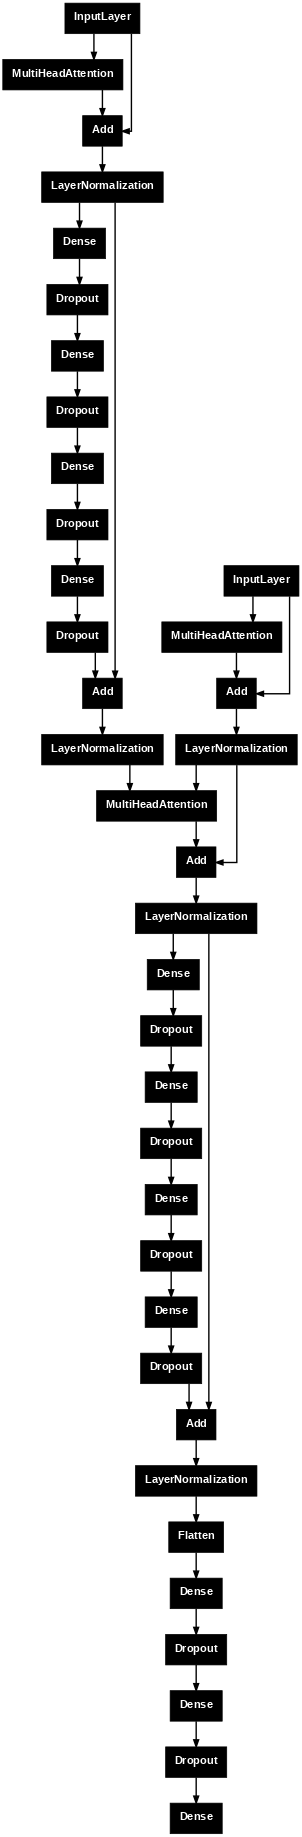

In [43]:
plot_model(model_1B, dpi=50)

## Training

In [44]:
path_model = '/content/drive/MyDrive/MyColabProject/Models/WithoutOOP'
checkpoint_filepath = (path_model+'/1B_Idea1_withoutOOP_1SF_nsepy_inp128_out1_FourierTransform_withInception.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/MyColabProject/Models/WithoutOOP/1B_Idea1_withoutOOP_1SF_nsepy_inp128_out1_FourierTransform_withInception.weights.h5


In [45]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=10,
                               mode="min",
                               restore_best_weights=True)

In [46]:
history_1 = model_1B.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        epochs=50, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - R2Score: -0.0225 - loss: 798.8788 - val_R2Score: 5.1999e-04 - val_loss: 67.5752 - learning_rate: 0.0010
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - R2Score: 0.0032 - loss: 63.1309 - val_R2Score: 0.0142 - val_loss: 54.2842 - learning_rate: 0.0010
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - R2Score: 0.0182 - loss: 53.3922 - val_R2Score: 0.0334 - val_loss: 52.2054 - learning_rate: 0.0010
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - R2Score: 0.0448 - loss: 52.9010 - val_R2Score: 0.0786 - val_loss: 49.6806 - learning_rate: 0.0010
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - R2Score: 0.0947 - loss: 49.6468 - val_R2Score: 0.1238 - val_loss: 47.4990 - learning_rate: 0.0010
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - R2Score: 0.1489 - loss: 48.2010 - val_R2Score: 0.1718 - val_loss: 44.8005 - learning_rate: 0.0010
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - R2Score: 0.172

In [ ]:
history_2 = model_1B.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        initial_epoch=50, epochs=100, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

In [ ]:
history_3 = model_1B.fit([X_train_mag_sft, X_train_ang_sft],y_train,
                        initial_epoch=100, epochs=200, batch_size=32,
                        shuffle = True,
                        validation_data=[[X_val_mag_sft, X_val_ang_sft], y_val],
                        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

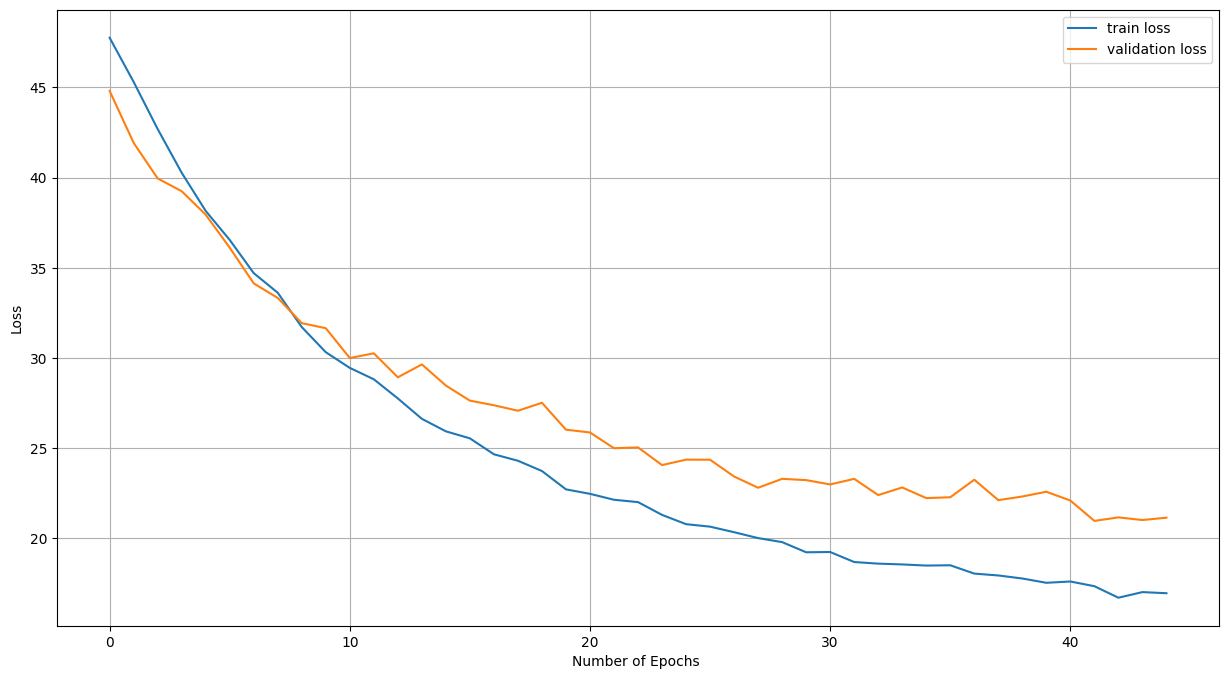

In [47]:
# Train Loss
train_loss = list(history_1.history['loss'])
#train_loss.extend(history_2.history['loss'])
#train_loss.extend(history_3.history['loss'])
#train_loss.extend(history_4.history['loss'])

# Validation Loss
val_loss = list(history_1.history['val_loss'])
#val_loss.extend(history_2.history['val_loss'])
#val_loss.extend(history_3.history['val_loss'])
#val_loss.extend(history_4.history['val_loss'])

# plot history
plt.plot(np.array(train_loss[5:]), label='train loss')
plt.plot(np.array(val_loss[5:]), label='validation loss')
plt.xlabel("Number of Epochs ")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## Prediction - from Model

In [48]:
predictions = model_1B(([X_test_mag_sft, X_test_ang_sft]), training=False)

In [49]:
predictions.shape

TensorShape([3840, 1])

In [50]:
predictions[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.1863675], dtype=float32)>

In [51]:
i = 12
print('Predictions = \n',predictions[i])
print('Actuals = \n',y_test[i])

Predictions = 
 tf.Tensor([-1.8695798], shape=(1,), dtype=float32)
Actuals = 
 [-0.9]


## Validating the results

In [52]:
y_pred = predictions.numpy().reshape(-1)
y_test = y_test.reshape(-1)
print(y_pred.shape)
print(y_test.shape)

(3840,)
(3840,)


In [53]:
score_mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error of our Model is {}".format(round(score_mae, 2)))
score_rmse = mean_squared_error(y_test, y_pred)
print("The Root Mean Squared Error of our Model is {}".format(round(score_rmse, 2)))
score_r2 = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score_r2, 2) *100))

The Mean Absolute Error of our Model is 2.86
The Root Mean Squared Error of our Model is 20.9
The accuracy of our model is 61.0%


In [54]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,10000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()

# Model 2

In [ ]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()

# Input Layer
input_mag_layer = Input(shape=(time_bins[index_for_testing], frequency_bins[index_for_testing]))
input_ang_layer = Input(shape=(time_bins[index_for_testing], frequency_bins[index_for_testing]))

# Layer 1 - self Attention for Angle (Multihead Attention + Add + LayerNorm)
lsa_ang_layer = MultiHeadAttention(num_heads=1,
                                   key_dim = frequency_bins[index_for_testing],
                                   kernel_initializer = initializer_for_relu,
                                   dropout=0.2)(input_ang_layer, input_ang_layer, input_ang_layer)
add_ang = Add()([input_ang_layer, lsa_ang_layer])
layerNorm_ang = LayerNormalization()(add_ang)

# Layer 2 - FFN for Angle (Dense + Add + LayerNorm)
dense_ang_1 = Dense(time_bins[index_for_testing] * frequency_bins[index_for_testing],
                    activation='relu',
                    kernel_initializer=initializer_for_relu)(layerNorm_ang)
dense_ang_2 = Dense(frequency_bins[index_for_testing] ,
                    activation='relu',
                    kernel_initializer=initializer_for_relu)(dense_ang_1)
add_ffn_ang = Add()([layerNorm_ang, dense_ang_2])
layerNorm_ffn_mag = LayerNormalization()(add_ffn_ang)


# Layer 3 - self Attention for Magnitude (Multihead Attention + Add + LayerNorm)
lsa_mag_layer = MultiHeadAttention(num_heads=1,
                                   key_dim = frequency_bins[index_for_testing],
                                   kernel_initializer = initializer_for_relu,
                                   dropout=0.2)(input_mag_layer, input_mag_layer, input_mag_layer)
add_mag = Add()([input_mag_layer, lsa_mag_layer])
layerNorm_mag = LayerNormalization()(add_mag)

# Layer 4 - Cross Attention for Magnitude and Angle (Multihead Attention + Add + LayerNorm)
gca_layer = MultiHeadAttention(num_heads=1,
                               key_dim = frequency_bins[index_for_testing],
                               kernel_initializer = initializer_for_relu,
                               dropout=0.2)(layerNorm_mag, layerNorm_ffn_mag, layerNorm_ffn_mag)
add_gca = Add()([layerNorm_mag, gca_layer])
layerNorm_gca = LayerNormalization()(add_gca)

# Layer 5 - FFN for Global Cross Attention (Dense + Add + LayerNorm)
dense_gca_1 = Dense(time_bins[index_for_testing] * frequency_bins[index_for_testing],
                    activation='relu',
                    kernel_initializer=initializer_for_relu)(layerNorm_gca)
dense_gca_2 = Dense(frequency_bins[index_for_testing] ,
                    activation='relu',
                    kernel_initializer=initializer_for_relu)(dense_gca_1)
add_ffn_gca = Add()([layerNorm_gca, dense_gca_2])
layerNorm_ffn_gca = LayerNormalization()(add_ffn_gca)

# Layer 6 - Dense / Convolution
out_conv_layer = Conv1D(filters=tf.get_static_value(tf.cast(signal_length/4, dtype=tf.int32)),
                        kernel_size=time_bins[index_for_testing],
                        activation='relu',
                        kernel_initializer=initializer_for_relu,
                        input_shape = (time_bins[index_for_testing], frequency_bins[index_for_testing]))(layerNorm_ffn_gca)

flatten_layer = Flatten()(out_conv_layer)

# Output Layer
model_2 = Model(inputs=[input_mag_layer,input_ang_layer], outputs=flatten_layer)

In [ ]:
model_2.compile(loss = 'mean_squared_error', optimizer = 'adam')

#Model Summary
model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2, 33)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 2, 33)          │          4,488 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 2, 33)          │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 2, 33)          │             66 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 2, 33)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2, 66)          │          2,244 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 2, 33)          │          4,488 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2, 33)          │          2,211 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 2, 33)          │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 2, 33)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 2, 33)          │             66 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 2, 33)          │             66 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 2, 33)          │          4,488 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
│                           │                        │                │ layer_normalization_1… │
├──────────────────────

 Total params: 24,848 (97.06 KB)

 Trainable params: 24,848 (97.06 KB)

 Non-trainable params: 0 (0.00 B)

# Failed Models

# Success Models

In [ ]:
# 1st Best model
# Input formation
'''
data_q1 = data_df.iloc[:13200,:129].copy()
data_q2 = data_df.iloc[:13200,128:257].copy()
data_q3 = data_df.iloc[:13200,256:385].copy()
data_q4 = data_df.iloc[:13200,384:].copy()
data_df_merged = pd.DataFrame()
data_df_merged = pd.concat([pd.DataFrame(data_q1.values),pd.DataFrame(data_q2.values),pd.DataFrame(data_q3.values),pd.DataFrame(data_q4.values)],
                           ignore_index=True)
'''
# Inputs
'''
X Train shape (35640, 128)
Y Train shape (35640, 1)

X Validation shape (11880, 128)
Y Validation shape (11880, 1)

X Test shape (5280, 128)
Y Test shape (5280, 1)
'''
# Hyperparameters
'''
# Hyperparameters for Fourier Transform
signal_length = X_train.shape[1] # Length of the input time series
frame_length = [128, 64, 32] # Hop size for Fourier Transform
frame_size = len(frame_length)
frame_step = [64, 32, 16] # Hop size for Fourier Transform
fft_length = frame_length

# Hyperparameters for Attention Layer and DNN Layer
num_layers = [1, 2, 2] # number of TransformerEncoderLayer layers (Original paper = 6)
num_heads = [1, 1, 2] # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.4 # Dropout rate
regularizer_rate = 0.001  # Use to regularizer the weights in attention model, smaller number for less data


# The STFT output shape can be defined as:
# Output Shape = (batch_size, 𝐹, 𝑇)
time_bins = list()
frequency_bins = list()
for i in np.arange(frame_size):
  print(i)
  # Number of Time Frames (T)
  time_bins.append(int(((signal_length - fft_length[i])/frame_step[i] )+1 ))
  print('Time Bins =',time_bins[i])


0
Time Bins = 1
Frequency Bins = 65
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 1 , 65 )

1
Time Bins = 3
Frequency Bins = 33
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 3 , 33 )

2
Time Bins = 7
Frequency Bins = 17
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 7 , 17 )
'''

# Weights
'''
Model: "inception"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ transformer_layer (TransformerLayer) │ ?                           │          78,581 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer_1                  │ ?                           │          68,302 │
│ (TransformerLayer)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer_2                  │ ?                           │          48,128 │
│ (TransformerLayer)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (3, 1)                      │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 195,396 (763.27 KB)
 Trainable params: 194,352 (759.19 KB)
 Non-trainable params: 1,044 (4.08 KB)
'''

# Output
'''
Test
The Mean Absolute Error of our Model is 2.72
The Root Mean Squared Error of our Model is 27.64
The accuracy of our model is 59.0%